# AethraDB All Query Result Analysis Overview
This file contains the result analysis for the filter query aggregation and join queries at the current stage of development in the AethraDB engine. Additionally, it contains a comparison against a single-threaded run of the same queries on the same data on DuckDB version 0.7.1 using PyArrow 11.0.0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')
plt_patterns = ('-', 'x','/','\\','O','o','//','\\\\')

## Importing the Data
We first load the filter query benchmark data from DuckDB.

In [2]:
# Loading the filter query data from DuckDB
duckdb_filter_query_raw = pd.read_csv("./filter_query_duckdb.csv")

# Convert the running-time to milli-seconds
duckdb_filter_query = duckdb_filter_query_raw.copy(deep=True)
duckdb_filter_query["Running-Time"] = duckdb_filter_query["Running-Time"] * 1000
duckdb_filter_query["Running-Time"] = duckdb_filter_query["Running-Time"].round(1)

# Extract the restrictive column
duckdb_filter_query["Restrictive-Column"] = duckdb_filter_query.apply(lambda x: 1 if 'col1_002' in x['Dataset'] else (2 if 'col2_002' in x['Dataset'] else 3), axis=1)

# Drop the dataset column
duckdb_filter_query.drop(columns=['Dataset'], inplace=True)

# Introduce the "Engine" column
duckdb_filter_query["Engine"] = "DuckDB"

duckdb_filter_query.head()

,Running-Time,Restrictive-Column,Engine
0,105.1,1,DuckDB
1,103.7,2,DuckDB
2,104.5,3,DuckDB


Next, we load the aggregation query benchmark data from DuckDB.

In [3]:
# Loading the aggregation query data from DuckDB
duckdb_aggregation_query_raw = pd.read_csv("./aggregation_query_duckdb.csv")

# Convert the running-time to milli-seconds
duckdb_aggregation_query = duckdb_aggregation_query_raw.copy(deep=True)
duckdb_aggregation_query["Running-Time"] = duckdb_aggregation_query_raw["Running-Time"] * 1000
duckdb_aggregation_query["Running-Time"] = duckdb_aggregation_query["Running-Time"].round(1)

# Extract the number of elements in each dataset
duckdb_aggregation_query["Records"] = duckdb_aggregation_query.apply(lambda x: x['Dataset'].split('size_')[1], axis=1)
duckdb_aggregation_query["Records"] = duckdb_aggregation_query["Records"].str.extract('(\d+)').astype(int)

# Extract the number of keys in each dataset
duckdb_aggregation_query["Keys"] = duckdb_aggregation_query.apply(lambda x: x['Dataset'].split('keys_')[1], axis=1)
duckdb_aggregation_query["Keys"] = duckdb_aggregation_query["Keys"].str.extract('(\d+)').astype(int)

# Introduce the "Engine" column
duckdb_aggregation_query["Engine"] = "DuckDB"

# Split the dataset into the skew part and without skew part
duckdb_aggregation_query_no_skew = duckdb_aggregation_query[~duckdb_aggregation_query['Dataset'].str.contains("skew")].copy(deep=True)

# Drop the dataset column
duckdb_aggregation_query_no_skew.drop(columns=['Dataset'], inplace=True)

duckdb_aggregation_query_no_skew.head()

,Running-Time,Records,Keys,Engine
0,464.5,31457280,128,DuckDB
1,2750.5,31457280,524288,DuckDB
2,2381.6,31457280,262144,DuckDB
3,567.9,31457280,1024,DuckDB
4,461.7,31457280,16,DuckDB


Next, we load the join query data from DuckDB.

In [4]:
# Loading the aggregation query data from DuckDB
duckdb_join_query_raw = pd.read_csv("./join_query_duckdb.csv")

# Convert the running-time to milli-seconds
duckdb_join_query = duckdb_join_query_raw.copy(deep=True)
duckdb_join_query["Running-Time"] = duckdb_join_query["Running-Time"] * 1000
duckdb_join_query["Running-Time"] = duckdb_join_query["Running-Time"].round(1)

# Extract the join selectivity
duckdb_join_query["B_Selectivity"] = duckdb_join_query.apply(lambda x: x['Dataset'].split('/A_B_')[1], axis=1)
duckdb_join_query["C_Selectivity"] = duckdb_join_query.apply(lambda x: x['B_Selectivity'].split('_C_')[1], axis=1)
duckdb_join_query["B_Selectivity"] = duckdb_join_query.apply(lambda x: x['B_Selectivity'].split('_C_')[0], axis=1)

# Introduce the "Engine" column
duckdb_join_query["Engine"] = "DuckDB"

# Introduce the "Dataset_ID" column
duckdb_join_query["Dataset_ID"] = duckdb_join_query.apply(lambda x: x['Dataset'].split('/A_')[1], axis=1)

# Drop the dataset column
duckdb_join_query.drop(columns=['Dataset'], inplace=True)

duckdb_join_query.head()

,Running-Time,B_Selectivity,C_Selectivity,Engine,Dataset_ID
0,669.5,0.8,0.8,DuckDB,B_0.8_C_0.8
1,614.0,0.8,0.2,DuckDB,B_0.8_C_0.2
2,618.2,0.6,0.8,DuckDB,B_0.6_C_0.8
3,520.9,0.4,0.2,DuckDB,B_0.4_C_0.2
4,570.8,0.6,0.2,DuckDB,B_0.6_C_0.2


Finally, we load the data from the AethraDB experiments themselves.

In [5]:
# Load there result from AethraDB
aethra_result_raw = pd.read_csv("aethra-result.csv")

# Take only the average rows and rename the "Score" column to "Running-Time"
aethra_results = aethra_result_raw[~aethra_result_raw['Benchmark'].str.contains('executeFilterQuery:executeFilterQuery')]
aethra_results = aethra_results[~aethra_results['Benchmark'].str.contains('executeQuery:executeQuery')].copy(deep=True)
aethra_results["Running-Time"] = aethra_results["Score"].round(1)

# Introduce the "Engine" column
aethra_results["Engine"] = aethra_results.apply(
    lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
    else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
          else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark']
                else "V-S")), axis=1)

# Split the result into a filter-query, an aggregation query and a join-query dataset
aethra_filter_query_result = aethra_results[aethra_results['Benchmark'].str.contains("filter_query")].copy(deep=True)
aethra_aggregation_query_result = aethra_results[aethra_results['Benchmark'].str.contains("aggregation_query")].copy(deep=True)
aethra_join_query_result = aethra_results[aethra_results['Benchmark'].str.contains("join_query")].copy(deep=True)

# For the filter-query dataset, extract the restrictive column
aethra_filter_query_result["Restrictive-Column"] = aethra_filter_query_result.apply(lambda x: 1 if 'col1_002' in x['Param: tableFilePath'] else (2 if 'col2_002' in x['Param: tableFilePath'] else 3), axis=1)

# For the filter-query dataset drop all columns except the "Running-Time" and "Restrictive-Column"
aethra_filter_query_result.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath", "Param: initialMapSize", "Param: tpchInstance"], inplace=True)

# For the aggregation query, extract the number of elements in each dataset
aethra_aggregation_query_result["Records"] = aethra_aggregation_query_result.apply(lambda x: x['Param: tableFilePath'].split('size_')[1], axis=1)
aethra_aggregation_query_result["Records"] = aethra_aggregation_query_result["Records"].str.extract('(\d+)').astype(int)

# For the aggregation query, extract the number of keys in each dataset
aethra_aggregation_query_result["Keys"] = aethra_aggregation_query_result.apply(lambda x: x['Param: tableFilePath'].split('keys_')[1], axis=1)
aethra_aggregation_query_result["Keys"] = aethra_aggregation_query_result["Keys"].str.extract('(\d+)').astype(int)

# For the aggregation query, mark if the benchmark instance is a hard-coded instance
aethra_aggregation_query_result["Hardcoded"] = aethra_aggregation_query_result['Benchmark'].str.contains("hard_coded")

# For the aggregation query, split the dataset into the skew part and without skew part
aethra_aggregation_query_result_no_skew = aethra_aggregation_query_result[~aethra_aggregation_query_result["Param: tableFilePath"].str.contains("skew")].copy(deep=True)

# Drop the dataset column of the aggregation query that we do not need
aethra_aggregation_query_result_no_skew.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath", "Param: initialMapSize", "Param: tpchInstance"], inplace=True)

# For the join query, extract the selectivity per join column
aethra_join_query_result["B_Selectivity"] = aethra_join_query_result.apply(lambda x: x['Param: tableFilePath'].split('/A_B_')[1], axis=1)
aethra_join_query_result["C_Selectivity"] = aethra_join_query_result.apply(lambda x: x['B_Selectivity'].split('_C_')[1], axis=1)
aethra_join_query_result["B_Selectivity"] = aethra_join_query_result.apply(lambda x: x['B_Selectivity'].split('_C_')[0], axis=1)

# For the join query, introduce the Dataset_ID column
aethra_join_query_result["Dataset_ID"] = aethra_join_query_result.apply(lambda x: x['Param: tableFilePath'].split('/A_')[1], axis=1)

# For the join query, mark if the benchmark instance is a hard-coded instance
aethra_join_query_result["Hardcoded"] = aethra_join_query_result['Benchmark'].str.contains("hard_coded")

# For the join query, drop the columns that we do not need
aethra_join_query_result.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath", "Param: initialMapSize", "Param: tpchInstance"], inplace=True)

In [6]:
aethra_filter_query_result.head()

,Running-Time,Engine,Restrictive-Column
846,70.0,NV-NS,1
855,71.5,NV-NS,2
864,72.3,NV-NS,3
873,72.0,NV-S,1
882,72.3,NV-S,2


In [7]:
aethra_aggregation_query_result_no_skew.head()

,Running-Time,Engine,Records,Keys,Hardcoded
0,346.9,NV-NS,31457280,2,False
9,460.8,NV-NS,31457280,16,False
18,440.3,NV-NS,31457280,128,False
27,476.8,NV-NS,31457280,1024,False
36,601.5,NV-NS,31457280,8192,False


In [8]:
aethra_join_query_result.head()

,Running-Time,Engine,B_Selectivity,C_Selectivity,Dataset_ID,Hardcoded
954,2713.9,NV-NS,0.2,0.2,B_0.2_C_0.2,False
963,2835.3,NV-NS,0.2,0.8,B_0.2_C_0.8,False
972,3359.4,NV-NS,0.4,0.2,B_0.4_C_0.2,False
981,3534.8,NV-NS,0.4,0.8,B_0.4_C_0.8,False
990,4651.4,NV-NS,0.6,0.2,B_0.6_C_0.2,False


## Analysing the Filter Query Performance
We create a plot of the running-time per engine and per restrictive column for the filter query.

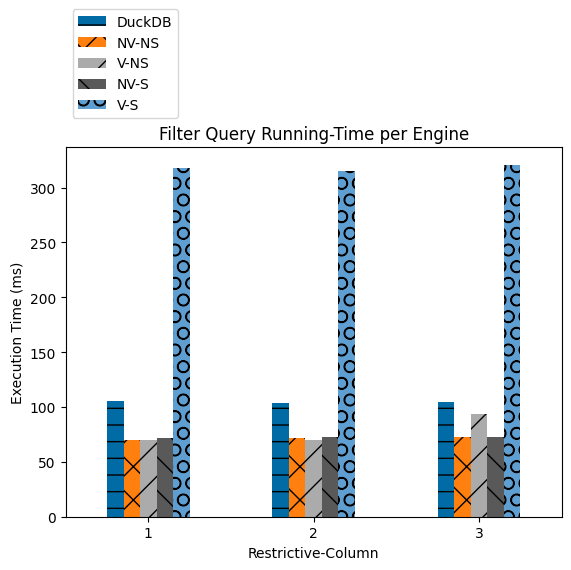

In [9]:
index_column = "Restrictive-Column"

duckdb_data = duckdb_filter_query.sort_values(index_column)
index = duckdb_data[index_column]

aethra_nv_ns_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0)
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Filter Query Running-Time per Engine")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

## Analysing the Aggregation Query Performance (Influence of #Keys, no Skew)
Below we analyse the performance of the Aggregation Query for each engine, where we focus on the influence of the amount of unique keys in the aggregation. We present results both for the query implementations that check the final result, and those that do not check the result. 

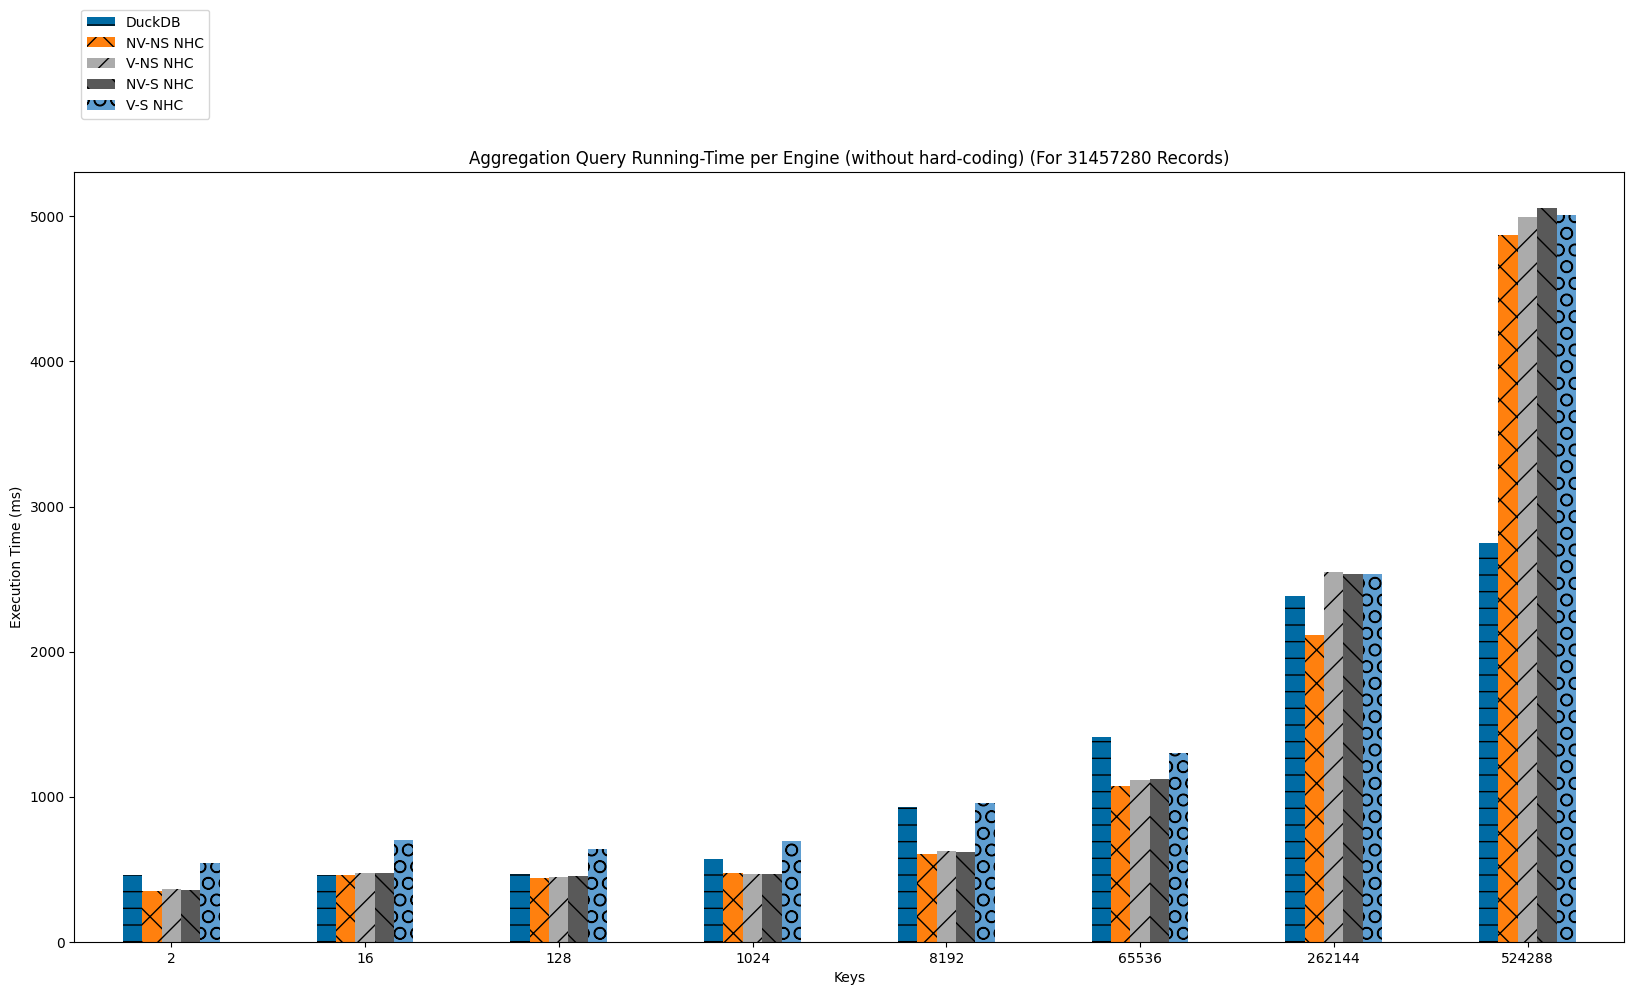

In [10]:
index_column = "Keys"

duckdb_data = duckdb_aggregation_query_no_skew.sort_values(index_column)
index = duckdb_data[index_column]

aethra_nv_ns_data = aethra_aggregation_query_result_no_skew[aethra_aggregation_query_result_no_skew["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_aggregation_query_result_no_skew[aethra_aggregation_query_result_no_skew["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_aggregation_query_result_no_skew[aethra_aggregation_query_result_no_skew["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_aggregation_query_result_no_skew[aethra_aggregation_query_result_no_skew["Engine"] == "V-S"].sort_values(index_column)

aethra_nv_ns_data_nhc = aethra_nv_ns_data[~aethra_nv_ns_data["Hardcoded"]]
aethra_nv_s_data_nhc = aethra_nv_s_data[~aethra_nv_s_data["Hardcoded"]]
aethra_v_ns_data_nhc = aethra_v_ns_data[~aethra_v_ns_data["Hardcoded"]]
aethra_v_s_data_nhc = aethra_v_s_data[~aethra_v_s_data["Hardcoded"]]
aethra_nv_ns_data_hc = aethra_nv_ns_data[aethra_nv_ns_data["Hardcoded"]]
aethra_nv_s_data_hc = aethra_nv_s_data[aethra_nv_s_data["Hardcoded"]]
aethra_v_ns_data_hc = aethra_v_ns_data[aethra_v_ns_data["Hardcoded"]]
aethra_v_s_data_hc = aethra_v_s_data[aethra_v_s_data["Hardcoded"]]

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS NHC': aethra_nv_ns_data_nhc["Running-Time"].tolist(),
    'V-NS NHC': aethra_v_ns_data_nhc["Running-Time"].tolist(),
    'NV-S NHC': aethra_nv_s_data_nhc["Running-Time"].tolist(),
    'V-S NHC': aethra_v_s_data_nhc["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (without hard-coding) (For 31457280 Records)")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

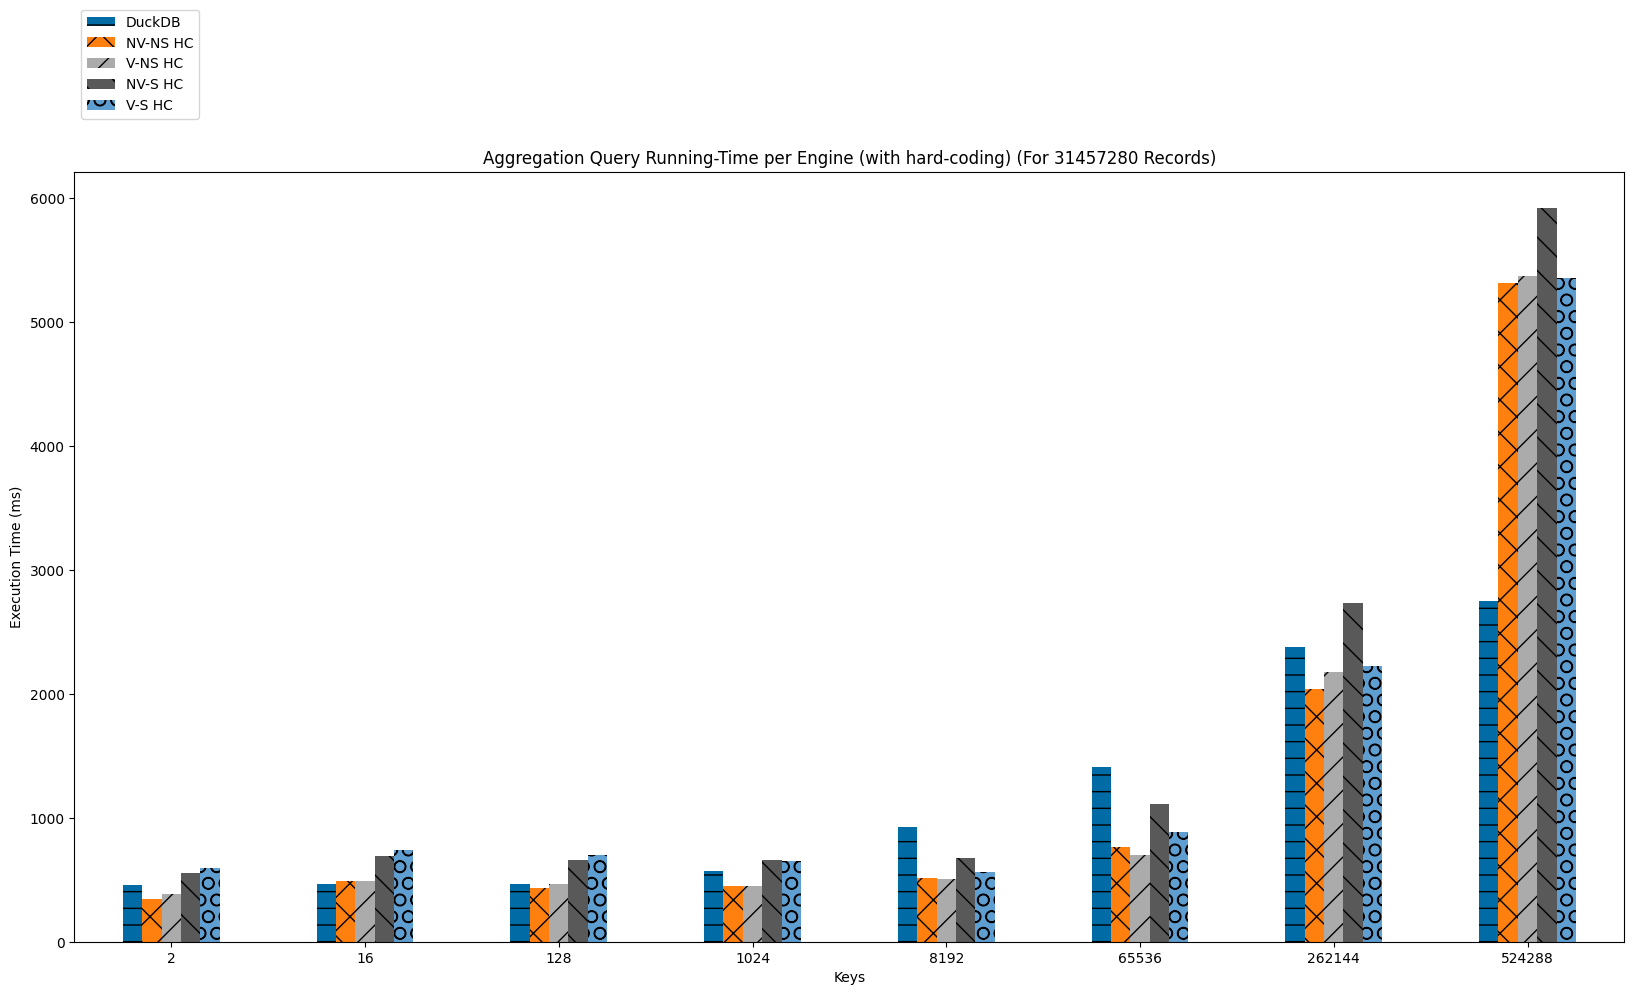

In [11]:
df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS HC': aethra_nv_ns_data_hc["Running-Time"].tolist(),
    'V-NS HC': aethra_v_ns_data_hc["Running-Time"].tolist(),
    'NV-S HC': aethra_nv_s_data_hc["Running-Time"].tolist(),
    'V-S HC': aethra_v_s_data_hc["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (with hard-coding) (For 31457280 Records)")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

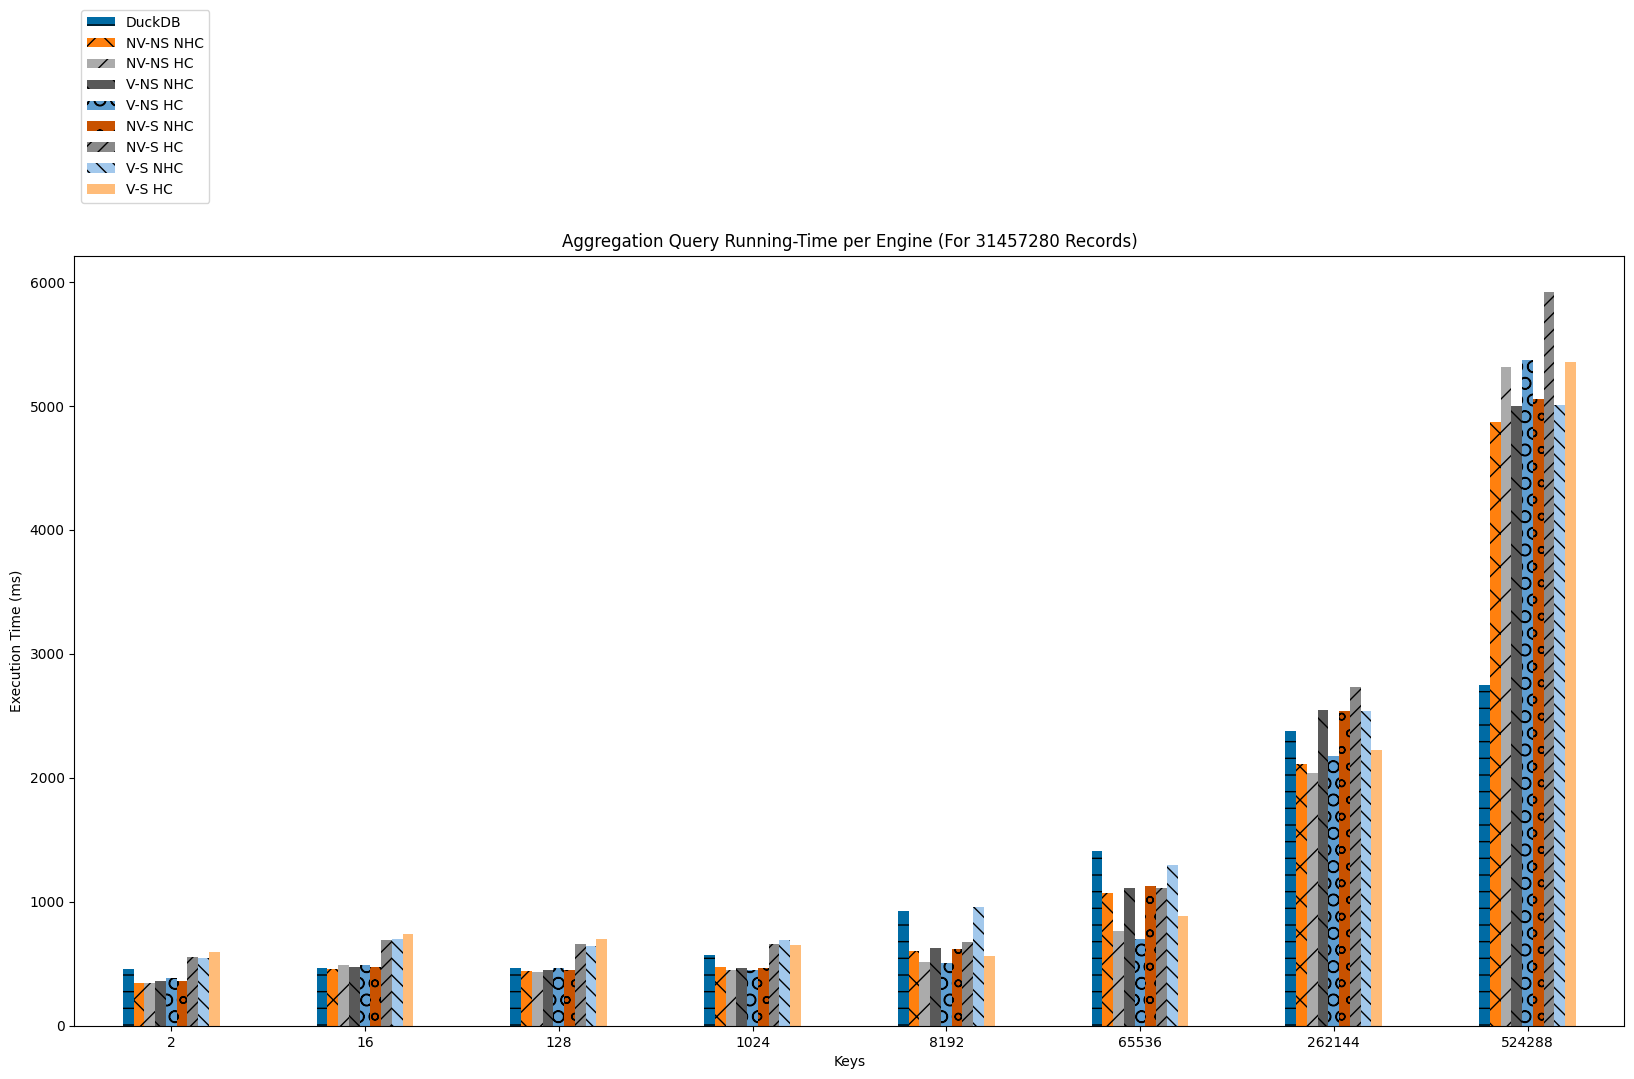

In [12]:
df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS NHC': aethra_nv_ns_data_nhc["Running-Time"].tolist(),
    'NV-NS HC': aethra_nv_ns_data_hc["Running-Time"].tolist(),
    'V-NS NHC': aethra_v_ns_data_nhc["Running-Time"].tolist(),
    'V-NS HC': aethra_v_ns_data_hc["Running-Time"].tolist(),
    'NV-S NHC': aethra_nv_s_data_nhc["Running-Time"].tolist(),
    'NV-S HC': aethra_nv_s_data_hc["Running-Time"].tolist(),
    'V-S NHC': aethra_v_s_data_nhc["Running-Time"].tolist(),
    'V-S HC': aethra_v_s_data_hc["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (For 31457280 Records)")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

## Analysing the Join Query Performance
Below we analyse the performance of the Join Query for each engine. The different datasets indicate the different join selectivity levels.

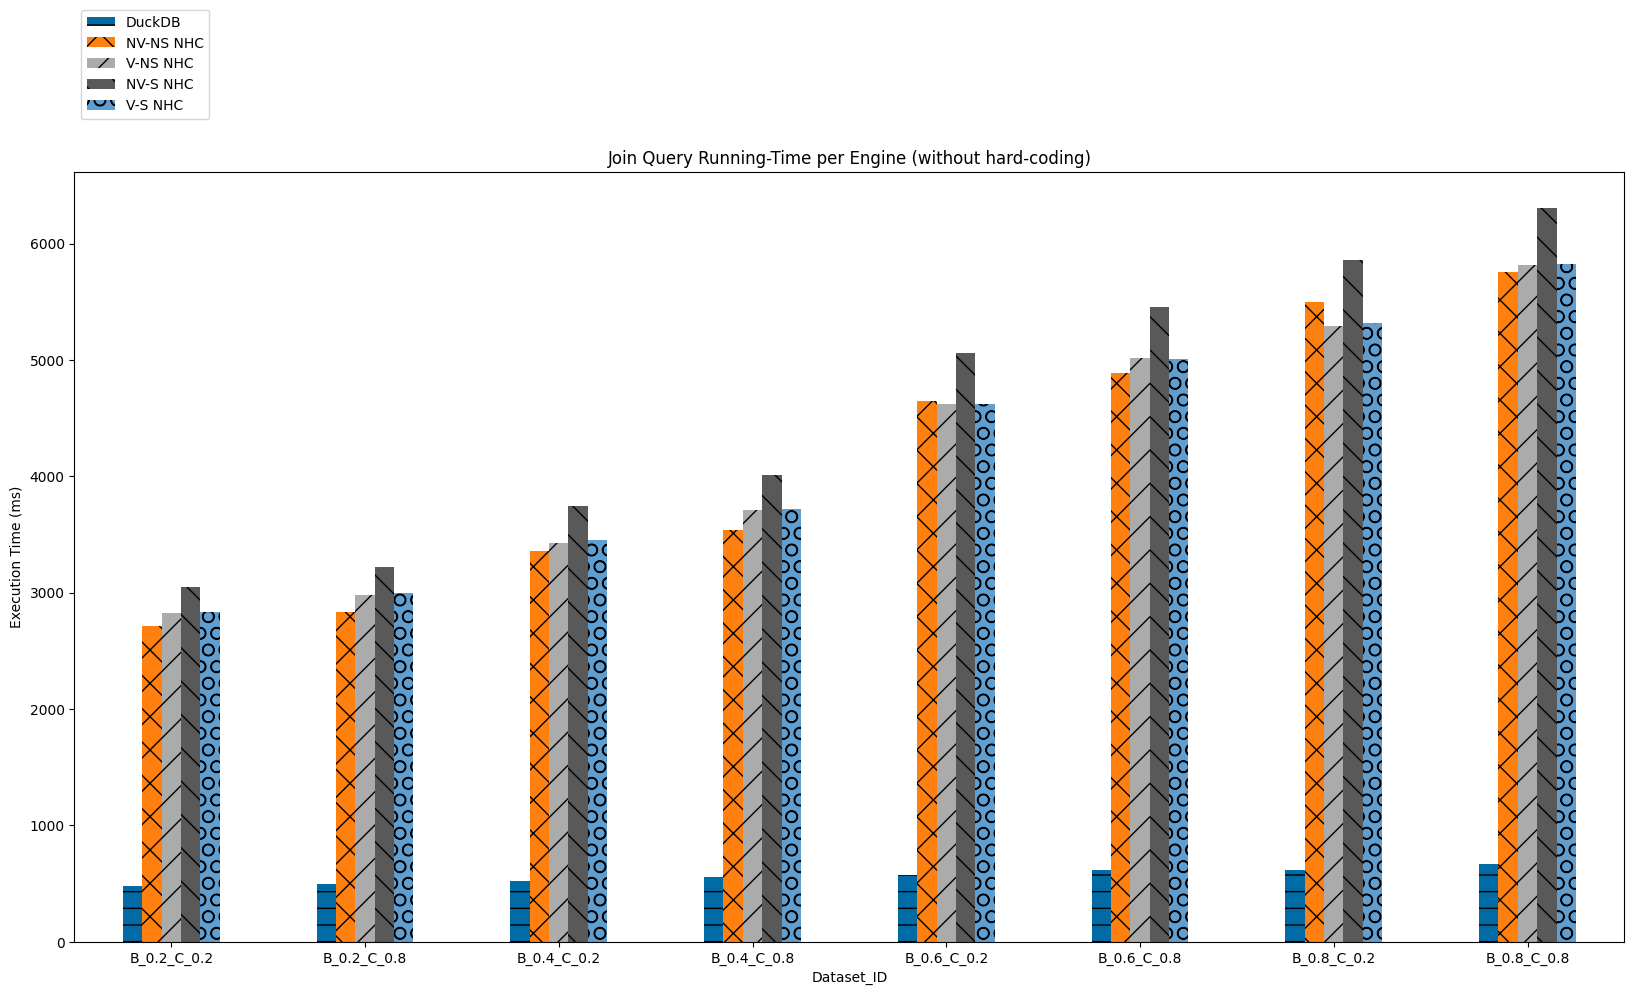

In [13]:
index_column = "Dataset_ID"

duckdb_data = duckdb_join_query.sort_values(index_column)
index = duckdb_data[index_column]

aethra_nv_ns_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "V-S"].sort_values(index_column)

aethra_nv_ns_data_NHC = aethra_nv_ns_data[~aethra_nv_ns_data["Hardcoded"]]
aethra_nv_s_data_NHC = aethra_nv_s_data[~aethra_nv_s_data["Hardcoded"]]
aethra_v_ns_data_NHC = aethra_v_ns_data[~aethra_v_ns_data["Hardcoded"]]
aethra_v_s_data_NHC = aethra_v_s_data[~aethra_v_s_data["Hardcoded"]]
aethra_nv_ns_data_HC = aethra_nv_ns_data[aethra_nv_ns_data["Hardcoded"]]
aethra_nv_s_data_HC = aethra_nv_s_data[aethra_nv_s_data["Hardcoded"]]
aethra_v_ns_data_HC = aethra_v_ns_data[aethra_v_ns_data["Hardcoded"]]
aethra_v_s_data_HC = aethra_v_s_data[aethra_v_s_data["Hardcoded"]]

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS NHC': aethra_nv_ns_data_NHC["Running-Time"].tolist(),
    'V-NS NHC': aethra_v_ns_data_NHC["Running-Time"].tolist(),
    'NV-S NHC': aethra_nv_s_data_NHC["Running-Time"].tolist(),
    'V-S NHC': aethra_v_s_data_NHC["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Join Query Running-Time per Engine (without hard-coding)")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

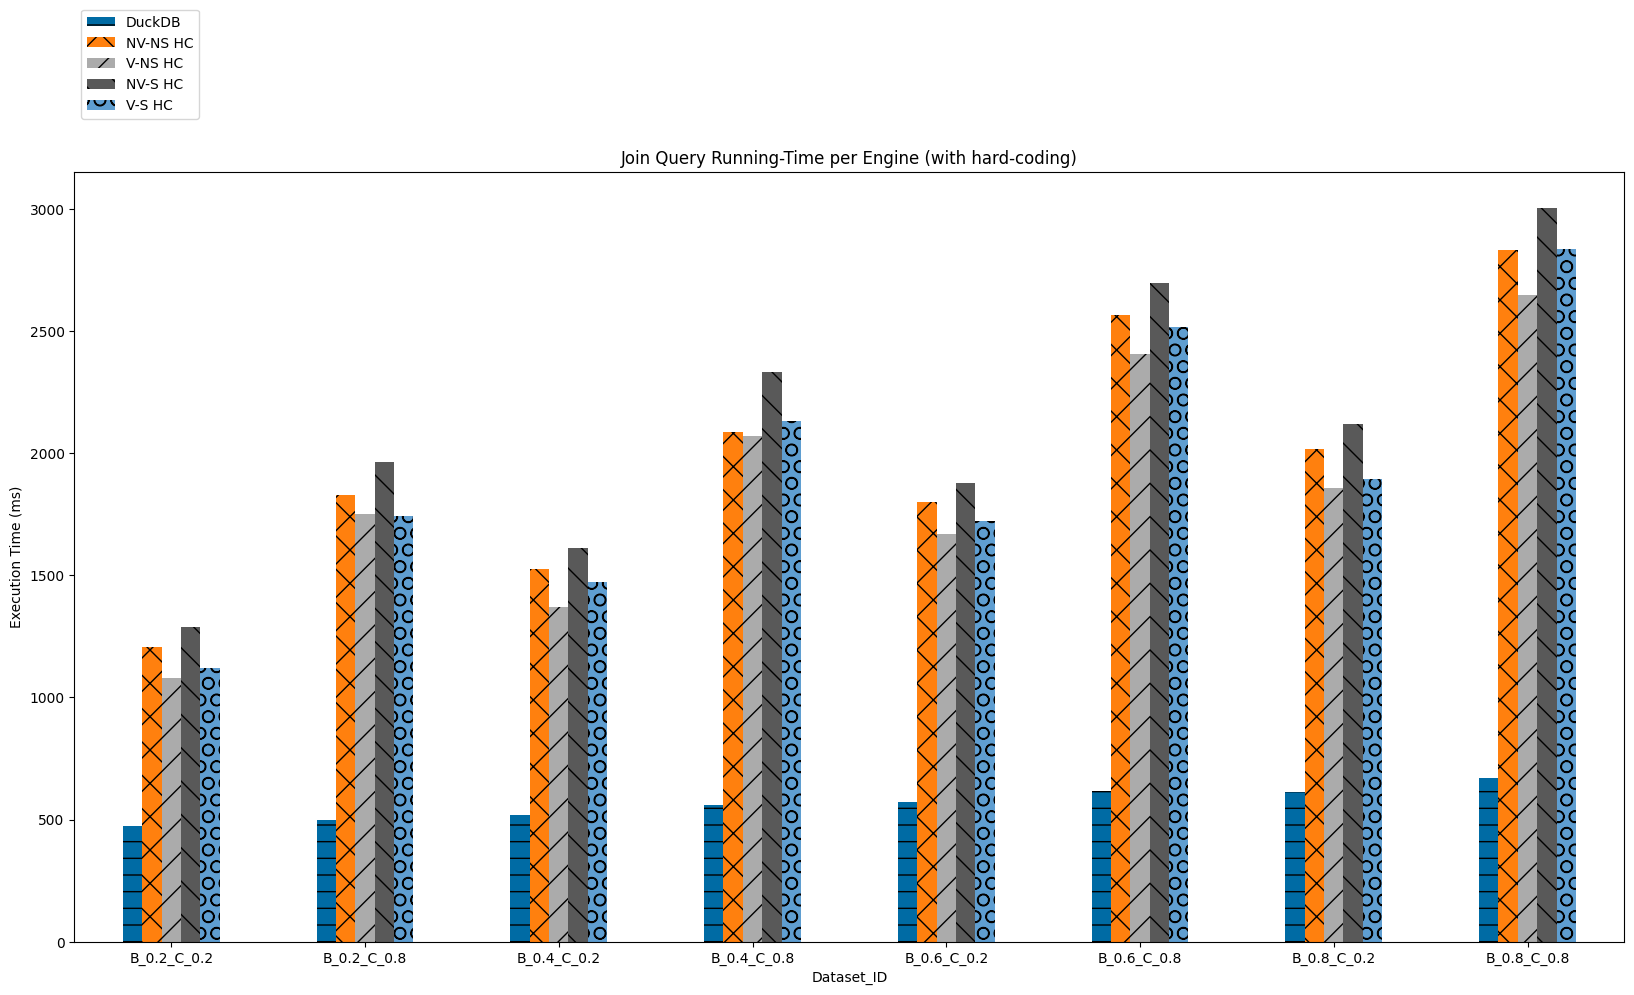

In [14]:
df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS HC': aethra_nv_ns_data_HC["Running-Time"].tolist(),
    'V-NS HC': aethra_v_ns_data_HC["Running-Time"].tolist(),
    'NV-S HC': aethra_nv_s_data_HC["Running-Time"].tolist(),
    'V-S HC': aethra_v_s_data_HC["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Join Query Running-Time per Engine (with hard-coding)")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

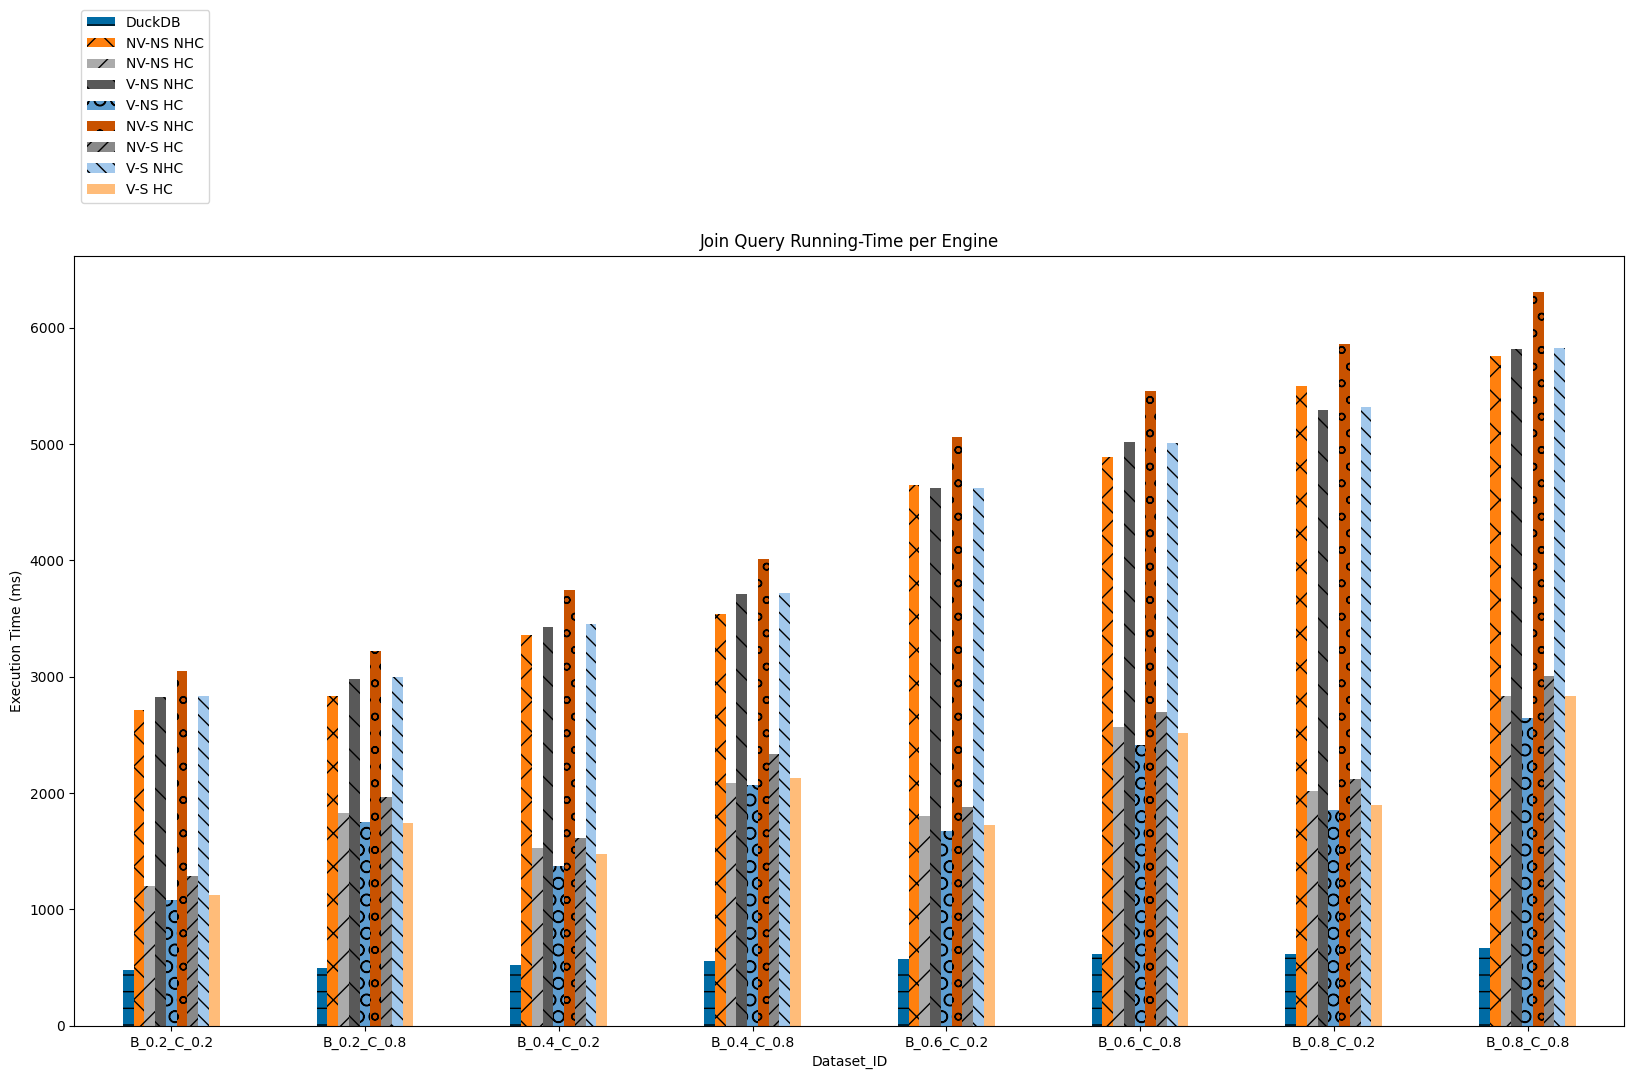

In [15]:
df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS NHC': aethra_nv_ns_data_NHC["Running-Time"].tolist(),
    'NV-NS HC': aethra_nv_ns_data_HC["Running-Time"].tolist(),
    'V-NS NHC': aethra_v_ns_data_NHC["Running-Time"].tolist(),
    'V-NS HC': aethra_v_ns_data_HC["Running-Time"].tolist(),
    'NV-S NHC': aethra_nv_s_data_NHC["Running-Time"].tolist(),
    'NV-S HC': aethra_nv_s_data_HC["Running-Time"].tolist(),
    'V-S NHC': aethra_v_s_data_NHC["Running-Time"].tolist(),
    'V-S HC': aethra_v_s_data_HC["Running-Time"].tolist()
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Join Query Running-Time per Engine")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

## TPC-H Query Analysis
In the section below we study the performance of the three TPC-H queries that are currently supported by the AethraDB engine.

In [16]:
# First we load the data
aethra_results_tpch = aethra_results[aethra_results["Benchmark"].str.contains("benchmarks.tpch")].copy(deep=True)

# Update the engine column to account for reduced mask benchmarks
aethra_results_tpch["Engine"] = aethra_results_tpch.apply(
    lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
    else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
          else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark'] and "Red" not in x['Benchmark']
                else ("V-NS-Red" if 'VectorisedNonSimd' in x['Benchmark']
                      else ("V-S" if 'VectorisedSimd' in x['Benchmark'] and "Red" not in x['Benchmark']
                           else "V-S-Red")))), axis=1)

# Next create a column indicating the TPC-H Query
aethra_results_tpch["Query"] = aethra_results_tpch["Benchmark"].apply(lambda x: x.split(".")[2].replace("_hard_coded", ""))

# Introduce a column indicating whether the execution of the query is hard-coded
aethra_results_tpch["Hardcoded"] = aethra_results_tpch["Benchmark"].str.contains("hard_coded")

# Remove columns that are no longer necessary
aethra_results_tpch.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath", "Param: initialMapSize", "Param: tpchInstance"], inplace=True)

# Print the resulting data for verification
aethra_results_tpch

,Running-Time,Engine,Query,Hardcoded
1692,254.1,NV-NS,q1_no_sort,True
1701,297.6,NV-S,q1_no_sort,True
1710,497.5,V-NS,q1_no_sort,True
1719,478.1,V-NS-Red,q1_no_sort,True
1728,501.7,V-S,q1_no_sort,True
1737,581.6,V-S-Red,q1_no_sort,True
1746,244.2,NV-NS,q3_no_sort,True
1755,441.9,NV-S,q3_no_sort,True
1764,236.5,V-NS,q3_no_sort,True
1773,245.1,V-NS-Red,q3_no_sort,True


In [17]:
# Load the DuckDB reference data
duckdb_tpch = pd.read_csv("./tpch_queries_duckdb.csv")

duckdb_tpch["Running-Time"] = duckdb_tpch["Running-Time"].round(1)

# Introduce the "Engine" column
duckdb_tpch["Engine"] = "DuckDB"

duckdb_tpch.head()

,Running-Time,Query,Engine
0,460.9,q1_no_sort,DuckDB
1,223.4,q3_no_sort,DuckDB
2,30.2,q6,DuckDB


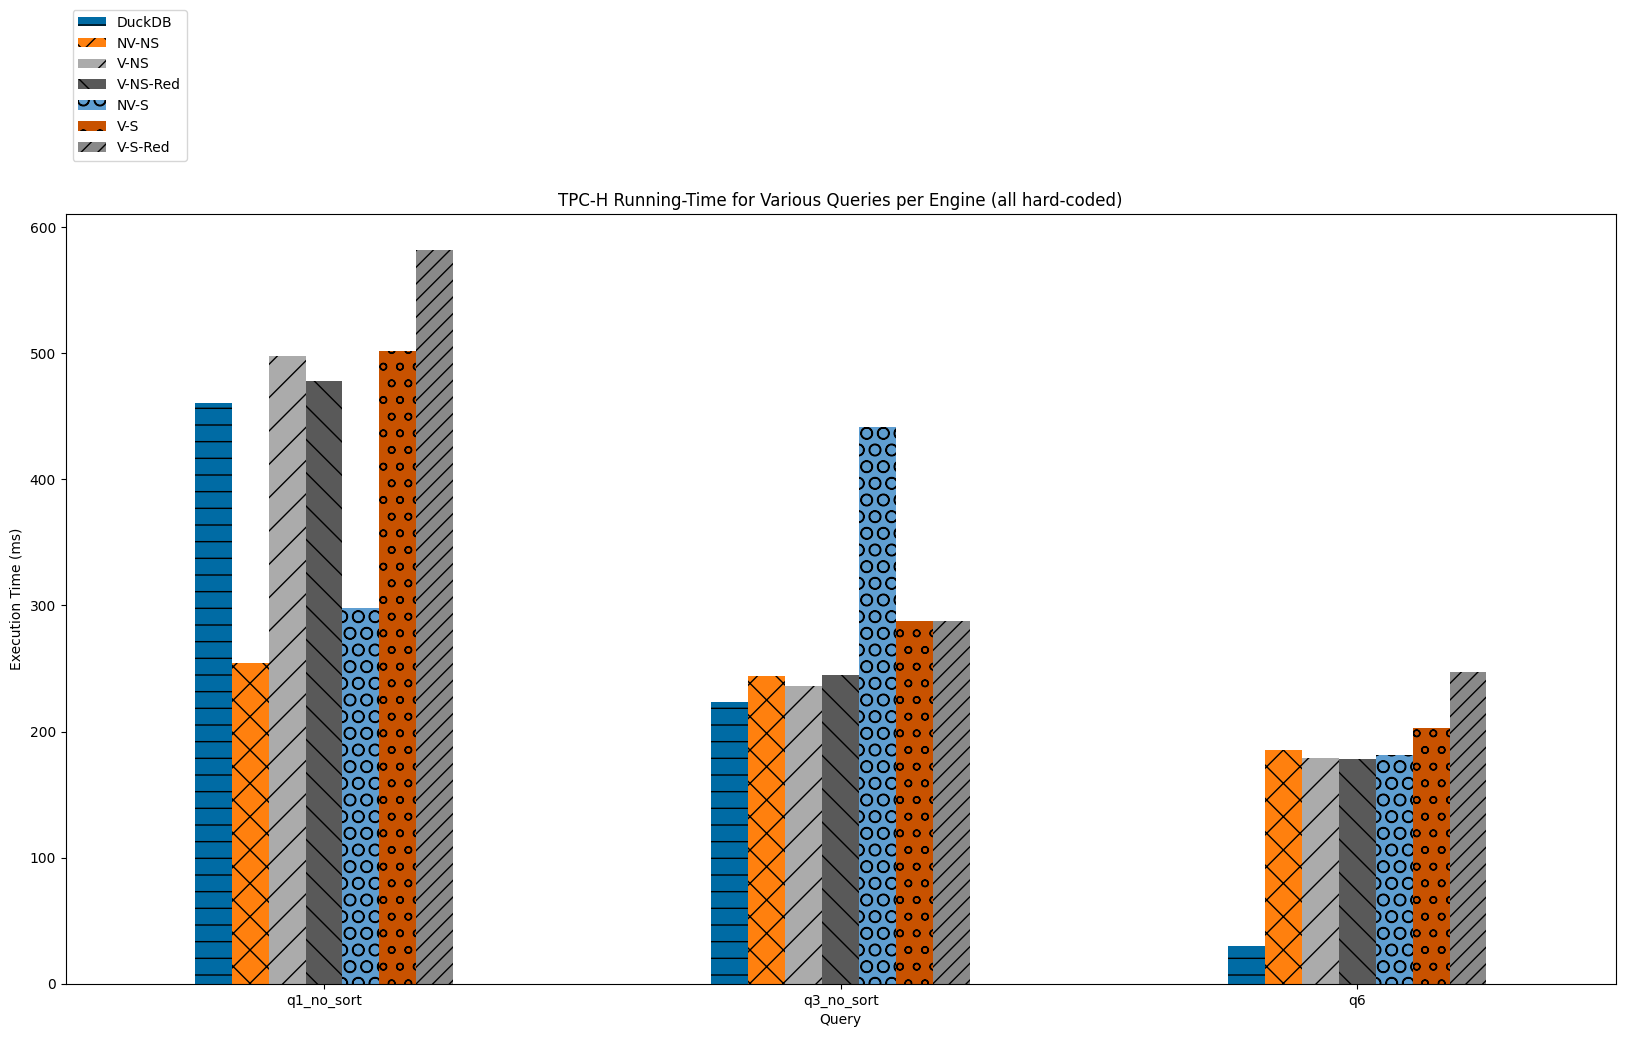

In [18]:
index_column = "Query"

duckdb_data = duckdb_tpch.sort_values(index_column)
index = duckdb_data[index_column]

aethra_nv_ns_data = aethra_results_tpch[aethra_results_tpch["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_results_tpch[aethra_results_tpch["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_results_tpch[aethra_results_tpch["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_ns_red_data = aethra_results_tpch[aethra_results_tpch["Engine"] == "V-NS-Red"].sort_values(index_column)
aethra_v_s_data = aethra_results_tpch[aethra_results_tpch["Engine"] == "V-S"].sort_values(index_column)
aethra_v_s_red_data = aethra_results_tpch[aethra_results_tpch["Engine"] == "V-S-Red"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'V-NS-Red': aethra_v_ns_red_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
    'V-S-Red': aethra_v_s_red_data["Running-Time"].tolist()
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("TPC-H Running-Time for Various Queries per Engine (all hard-coded)")

bars = ax.patches
hatches = [p for p in plt_patterns for i in range(len(df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))